In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.decomposition import PCA
from tqdm import tqdm
from scipy.optimize import fmin_powell

In [2]:
# Global constants
columns_to_exclude = ['Id', 'Response']
xgb_num_rounds = 720
num_classes = 8
missing_value_indicator = -1000


In [3]:
print("Loading data using pandas")
all_data = pd.read_csv("train.csv/train.csv")
all_data.head()


Loading data using pandas


,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8


In [4]:
all_data.dtypes

Id                      int64
Product_Info_1          int64
Product_Info_2         object
Product_Info_3          int64
Product_Info_4        float64
                       ...   
Medical_Keyword_45      int64
Medical_Keyword_46      int64
Medical_Keyword_47      int64
Medical_Keyword_48      int64
Response                int64
Length: 128, dtype: object

In [5]:
all_data.describe()

,Id,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
count,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,...,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000
mean,39507.211515,1.026355,24.415655,0.328952,2.006955,2.673599,1.043583,0.405567,0.707283,0.292587,...,0.056954,0.010054,0.045536,0.010710,0.007528,0.013691,0.008488,0.019905,0.054496,5.636837
std,22815.883089,0.160191,5.072885,0.282562,0.083107,0.739103,0.291949,0.197190,0.074239,0.089037,...,0.231757,0.099764,0.208479,0.102937,0.086436,0.116207,0.091737,0.139676,0.226995,2.456833
min,2.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19780.000000,1.000000,26.000000,0.076923,2.000000,3.000000,1.000000,0.238806,0.654545,0.225941,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,39487.000000,1.000000,26.000000,0.230769,2.000000,3.000000,1.000000,0.402985,0.709091,0.288703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
75%,59211.000000,1.000000,26.000000,0.487179,2.000000,3.000000,1.000000,0.567164,0.763636,0.345188,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
max,79146.000000,2.000000,38.000000,1.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000


In [6]:
# Determine which columns contain nulls/missing values.
cols_with_missing = [col for col in all_data.columns
                     if all_data[col].isnull().any()]

# Summarise how many missing values are present in each column.
all_data[cols_with_missing].isna().sum()

Employment_Info_1         19
Employment_Info_4       6779
Employment_Info_6      10854
Insurance_History_5    25396
Family_Hist_2          28656
Family_Hist_3          34241
Family_Hist_4          19184
Family_Hist_5          41811
Medical_History_1       8889
Medical_History_10     58824
Medical_History_15     44596
Medical_History_24     55580
Medical_History_32     58274
dtype: int64

In [7]:
## Calculate the proportion of zeroes relative to non-zero values.
for col in cols_with_missing:
    sum = all_data[col].isna().sum()
    length = len(all_data[col].index)
    ratio = sum/length
    print('Proportion of zeroes in', col, 'is: ', round(ratio*100,2), '%.')

Proportion of zeroes in Employment_Info_1 is:  0.03 %.
Proportion of zeroes in Employment_Info_4 is:  11.42 %.
Proportion of zeroes in Employment_Info_6 is:  18.28 %.
Proportion of zeroes in Insurance_History_5 is:  42.77 %.
Proportion of zeroes in Family_Hist_2 is:  48.26 %.
Proportion of zeroes in Family_Hist_3 is:  57.66 %.
Proportion of zeroes in Family_Hist_4 is:  32.31 %.
Proportion of zeroes in Family_Hist_5 is:  70.41 %.
Proportion of zeroes in Medical_History_1 is:  14.97 %.
Proportion of zeroes in Medical_History_10 is:  99.06 %.
Proportion of zeroes in Medical_History_15 is:  75.1 %.
Proportion of zeroes in Medical_History_24 is:  93.6 %.
Proportion of zeroes in Medical_History_32 is:  98.14 %.


In [8]:
# These columns have been selected as they contain a high proportion of blanks/missing values (deemed here as >40%) in the TRAINING dataset.
cols_to_delete_due_to_missing_data = ['Insurance_History_5',
                                      'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_5',
                                      'Medical_History_10', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32']

# Delete columns from ALL datasets where the proportion of zeroes in the TRAINING dataset exceeds a stipulated threshold.
#all_data = all_data.drop(cols_to_delete_due_to_missing_data, axis=1)

In [9]:

# Feature engineering
all_data['Product_Info_2_char'] = all_data['Product_Info_2'].str[0]
all_data['Product_Info_2_num'] = all_data['Product_Info_2'].str[1]

# Factorize categorical variables
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

# print('Eliminating missing values')
all_data.fillna(missing_value_indicator, inplace=True)

# Fix the dtype on the label column
all_data['Response'] = all_data['Response'].astype(int)


In [10]:
# Split train and test
training_set = all_data[all_data['Response'] > 0].copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    training_set.drop(columns_to_exclude, axis=1),
    training_set['Response'].values,
    train_size=0.8,
    test_size=0.2,
    random_state=0,
    stratify=training_set['Response'].values
)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.75, test_size=0.25, random_state=0, stratify=y_train)

In [11]:
pd.options.display.max_columns = X_train.shape[1]
X_train.describe(include='all')

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Product_Info_2_char,Product_Info_2_num,BMI_Age,Med_Keywords_Count
count,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.00000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000
mean,1

In [12]:
df_numerical_features = X_train.select_dtypes(include='number')
df_categorical_features = X_train.select_dtypes(include='category')
print('Numeric : ',df_numerical_features.columns)
print('Categorical : ',df_categorical_features.columns)

Numeric :  Index(['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_4',
       'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Ins_Age', 'Ht',
       'Wt',
       ...
       'Medical_Keyword_43', 'Medical_Keyword_44', 'Medical_Keyword_45',
       'Medical_Keyword_46', 'Medical_Keyword_47', 'Medical_Keyword_48',
       'Product_Info_2_char', 'Product_Info_2_num', 'BMI_Age',
       'Med_Keywords_Count'],
      dtype='object', length=130)
Categorical :  Index([], dtype='object')


In [13]:
#There is no need for categorical feature processing, we will be using tree based algorithms so normalising/scaling is not required as those algorithms are not sensitive to this pre-processing.
#We did expleriment with/without normalising but the results were not significant to make the extra computation.

In [14]:
#
# Quadratic Weighted Kappa objective
#
def kappa_weights(n):
    s = np.linspace(1, n, n)
    w = np.power(np.subtract.outer(s, s), 2.0) / np.power(np.subtract.outer(n, np.ones((n,))), 2)
    return w


def quadratic_weighted_kappa(a, b, n=8):
    a = np.clip(a.astype('int32') - 1, 0, n - 1)
    b = np.clip(b.astype('int32') - 1, 0, n - 1)

    sa = coo_matrix((np.ones(len(a)), (np.arange(len(a)), a)), shape=(len(a), n))
    sb = coo_matrix((np.ones(len(b)), (np.arange(len(b)), b)), shape=(len(a), n))

    O = (sa.T.dot(sb)).toarray()
    E = np.outer(sa.sum(axis=0), sb.sum(axis=0))
    E = np.divide(E, np.sum(E)) * O.sum()
    W = kappa_weights(n)

    return 1.0 - np.multiply(O, W).sum() / np.multiply(E, W).sum()



def eval_wrapper(yhat, y):
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)
    return quadratic_weighted_kappa(yhat, y)

# XGBoost parameters
def get_xgb_params():
    params = {
        "objective": "reg:linear",
        "eta": 0.05,
        "min_child_weight": 360,
        "subsample": 0.85,
        "colsample_bytree": 0.3,
        "silent": 1,
        "max_depth": 7
    }
    return list(params.items())


In [15]:
#This is before feature selection, basically we are letting the xgboost assign feature importance

In [16]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train #provide your own target name
)

# XGBoost model training
xgtrain = xgb.DMatrix(X_train, y_train, missing=missing_value_indicator)
xgvalidation = xgb.DMatrix(X_valid, y_valid, missing=missing_value_indicator)
xgtest = xgb.DMatrix(X_test, y_test, missing=missing_value_indicator)


xgb_params_list = get_xgb_params()
print(xgb_params_list)

model = xgb.train(xgb_params_list, xgtrain, xgb_num_rounds)

# Get feature importance
train_predictions = model.predict(xgtrain, ntree_limit=model.best_iteration)
print('Train score is:', eval_wrapper(train_predictions, y_train))


[('objective', 'reg:linear'), ('eta', 0.05), ('min_child_weight', 360), ('subsample', 0.85), ('colsample_bytree', 0.3), ('silent', 1), ('max_depth', 7)]
[17:09:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Train score is: 0.6503854987989881


c:\users\91808\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


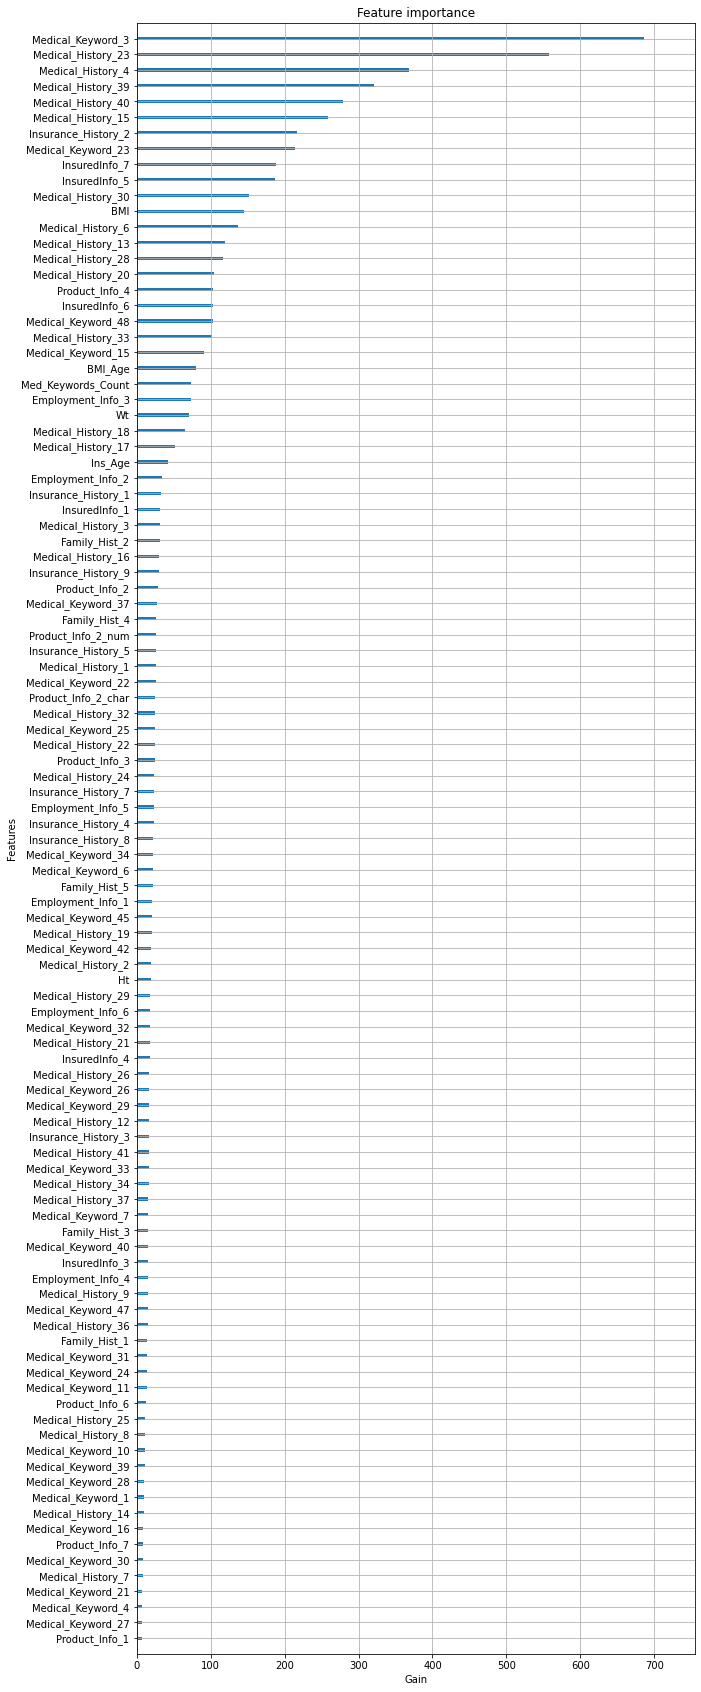

In [17]:
# Visualize feature importance
important_features = model.get_score(importance_type='gain')
important_features = dict(sorted(important_features.items(), key=lambda item: item[1], reverse=True))

fig, ax = plt.subplots(figsize=(10, 30))
plot_importance(model, importance_type="gain", xlabel="Gain", show_values=False, ax=ax)
plt.show()


In [18]:
# Feature selection using PCA
pca = PCA()
X_validation_pca = pca.fit_transform(X_valid)

X_validation_component_names = [f"PC{i+1}" for i in range(X_validation_pca.shape[1])]
X_validation_pca = pd.DataFrame(X_validation_pca, columns=X_validation_component_names)
X_validation_loadings = pd.DataFrame(pca.components_.T, columns=X_validation_component_names, index=X_valid.columns)
X_validation_loadings_first = X_validation_loadings.iloc[:, :80]

selected_columns = []

# Visualize which columns in the top PCs contain notable variance
for col in X_validation_loadings_first.columns:
    cols = X_validation_loadings_first[col].loc[abs(X_validation_loadings_first[col]) > 0.25]
    cols_df = pd.DataFrame(cols)
    selected_columns.append(cols_df)

#Count the occurance of each feature in every PC vector.
count_dict = {}

for row in selected_columns:
    for sub_row in row.index:
        if sub_row in count_dict:
            count_dict[sub_row] += 1
        else:
            count_dict[sub_row] = 1

#Sorting features decending, basically features with most count was deemed most imporant by PCA Algorithm.
count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))


In [19]:
best_score = 0
optimal_feature_number = 0
best_model = None
scores_list = []

# Feature selection based on the number of features
for features_count in tqdm(range(len(count_dict), 2, -1)):
    filtered_cols = list(count_dict.keys())[:features_count]
    X_train_filtered = X_train[filtered_cols]

    xgtrain = xgb.DMatrix(X_train_filtered, y_train, missing=missing_value_indicator)
    xgb_params_list = get_xgb_params()

    model = xgb.train(xgb_params_list, xgtrain, xgb_num_rounds)
    train_predictions = model.predict(xgtrain, ntree_limit=model.best_iteration)
    current_score = eval_wrapper(train_predictions, y_train)
    scores_list.append(current_score)
    print('Train score for '+str(features_count)+' :', current_score)
    if best_score < current_score:
        best_score = current_score
        optimal_feature_number = features_count
        best_model = model


  0%|                                                                                           | 0/92 [00:00<?, ?it/s]

[17:09:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




c:\users\91808\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
  1%|▉                                                                                  | 1/92 [00:07<11:10,  7.37s/it]

Train score for 94 : 0.6514480635288868
[17:09:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  2%|█▊                                                                                 | 2/92 [00:14<10:47,  7.19s/it]

Train score for 93 : 0.6482458264724201
[17:09:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  3%|██▋                                                                                | 3/92 [00:21<10:47,  7.27s/it]

Train score for 92 : 0.6486766306321533
[17:09:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  4%|███▌                                                                               | 4/92 [00:28<10:05,  6.88s/it]

Train score for 91 : 0.6463077395437851
[17:09:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  5%|████▌                                                                              | 5/92 [00:34<09:37,  6.64s/it]

Train score for 90 : 0.6403611592902027
[17:09:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  7%|█████▍                                                                             | 6/92 [00:40<09:17,  6.48s/it]

Train score for 89 : 0.6387746085953547
[17:10:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  8%|██████▎                                                                            | 7/92 [00:46<09:01,  6.37s/it]

Train score for 88 : 0.6402904358283228
[17:10:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  9%|███████▏                                                                           | 8/92 [00:52<08:49,  6.31s/it]

Train score for 87 : 0.639912387576383
[17:10:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 10%|████████                                                                           | 9/92 [00:58<08:37,  6.23s/it]

Train score for 86 : 0.6378654725788246
[17:10:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 11%|████████▉                                                                         | 10/92 [01:04<08:27,  6.19s/it]

Train score for 85 : 0.635044628281094
[17:10:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 12%|█████████▊                                                                        | 11/92 [01:11<08:19,  6.17s/it]

Train score for 84 : 0.6352250450459105
[17:10:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 13%|██████████▋                                                                       | 12/92 [01:17<08:13,  6.17s/it]

Train score for 83 : 0.63504103169894
[17:10:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 14%|███████████▌                                                                      | 13/92 [01:23<08:03,  6.12s/it]

Train score for 82 : 0.6348237180213694
[17:10:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 15%|████████████▍                                                                     | 14/92 [01:29<07:55,  6.09s/it]

Train score for 81 : 0.6351929602291265
[17:10:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 16%|█████████████▎                                                                    | 15/92 [01:35<07:49,  6.10s/it]

Train score for 80 : 0.6348734245330081
[17:10:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 17%|██████████████▎                                                                   | 16/92 [01:41<07:40,  6.06s/it]

Train score for 79 : 0.6341433723298425
[17:11:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 18%|███████████████▏                                                                  | 17/92 [01:47<07:33,  6.04s/it]

Train score for 78 : 0.6334178004747459
[17:11:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 20%|████████████████                                                                  | 18/92 [01:53<07:26,  6.04s/it]

Train score for 77 : 0.6321526370364686
[17:11:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 21%|████████████████▉                                                                 | 19/92 [01:59<07:19,  6.02s/it]

Train score for 76 : 0.6316461541188122
[17:11:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 22%|█████████████████▊                                                                | 20/92 [02:05<07:14,  6.04s/it]

Train score for 75 : 0.6326322363456096
[17:11:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 23%|██████████████████▋                                                               | 21/92 [02:11<07:06,  6.01s/it]

Train score for 74 : 0.6320804928549671
[17:11:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 24%|███████████████████▌                                                              | 22/92 [02:17<06:53,  5.91s/it]

Train score for 73 : 0.6265392826763045
[17:11:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 25%|████████████████████▌                                                             | 23/92 [02:22<06:41,  5.82s/it]

Train score for 72 : 0.6266305187522885
[17:11:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 26%|█████████████████████▍                                                            | 24/92 [02:28<06:37,  5.85s/it]

Train score for 71 : 0.624831667688087
[17:11:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 27%|██████████████████████▎                                                           | 25/92 [02:34<06:34,  5.88s/it]

Train score for 70 : 0.6247128032078868
[17:11:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 28%|███████████████████████▏                                                          | 26/92 [02:40<06:23,  5.81s/it]

Train score for 69 : 0.6234665664995553
[17:12:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 29%|████████████████████████                                                          | 27/92 [02:45<06:13,  5.75s/it]

Train score for 68 : 0.6242915482487571
[17:12:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 30%|████████████████████████▉                                                         | 28/92 [02:51<06:05,  5.71s/it]

Train score for 67 : 0.6239705169587368
[17:12:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 32%|█████████████████████████▊                                                        | 29/92 [02:56<05:56,  5.65s/it]

Train score for 66 : 0.6232840382379607
[17:12:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 33%|██████████████████████████▋                                                       | 30/92 [03:02<05:49,  5.64s/it]

Train score for 65 : 0.6226244361375322
[17:12:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 34%|███████████████████████████▋                                                      | 31/92 [03:08<05:41,  5.61s/it]

Train score for 64 : 0.6216615827660469
[17:12:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 35%|████████████████████████████▌                                                     | 32/92 [03:13<05:32,  5.54s/it]

Train score for 63 : 0.6117997206350156
[17:12:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 36%|█████████████████████████████▍                                                    | 33/92 [03:18<05:24,  5.50s/it]

Train score for 62 : 0.6104280559797681
[17:12:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 37%|██████████████████████████████▎                                                   | 34/92 [03:24<05:18,  5.50s/it]

Train score for 61 : 0.6113026017401636
[17:12:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 38%|███████████████████████████████▏                                                  | 35/92 [03:29<05:13,  5.50s/it]

Train score for 60 : 0.6102905634727539
[17:12:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 39%|████████████████████████████████                                                  | 36/92 [03:35<05:06,  5.46s/it]

Train score for 59 : 0.609729346728674
[17:12:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 40%|████████████████████████████████▉                                                 | 37/92 [03:40<04:58,  5.42s/it]

Train score for 58 : 0.6102527880890567
[17:13:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 41%|█████████████████████████████████▊                                                | 38/92 [03:45<04:49,  5.37s/it]

Train score for 57 : 0.594804921532049
[17:13:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 42%|██████████████████████████████████▊                                               | 39/92 [03:50<04:40,  5.29s/it]

Train score for 56 : 0.5940789991521926
[17:13:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 43%|███████████████████████████████████▋                                              | 40/92 [03:56<04:32,  5.25s/it]

Train score for 55 : 0.5949195483936984
[17:13:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 45%|████████████████████████████████████▌                                             | 41/92 [04:01<04:25,  5.20s/it]

Train score for 54 : 0.5945037291720794
[17:13:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 46%|█████████████████████████████████████▍                                            | 42/92 [04:06<04:19,  5.19s/it]

Train score for 53 : 0.5933251901090846
[17:13:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 47%|██████████████████████████████████████▎                                           | 43/92 [04:11<04:12,  5.16s/it]

Train score for 52 : 0.5944452863815513
[17:13:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 48%|███████████████████████████████████████▏                                          | 44/92 [04:16<04:06,  5.13s/it]

Train score for 51 : 0.5940909552876776
[17:13:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 49%|████████████████████████████████████████                                          | 45/92 [04:21<04:01,  5.13s/it]

Train score for 50 : 0.5937137817056812
[17:13:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 50%|█████████████████████████████████████████                                         | 46/92 [04:26<03:54,  5.09s/it]

Train score for 49 : 0.5917463608468125
[17:13:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 51%|█████████████████████████████████████████▉                                        | 47/92 [04:31<03:47,  5.05s/it]

Train score for 48 : 0.5853398468011297
[17:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 52%|██████████████████████████████████████████▊                                       | 48/92 [04:36<03:39,  4.98s/it]

Train score for 47 : 0.5811296059117658
[17:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 53%|███████████████████████████████████████████▋                                      | 49/92 [04:40<03:28,  4.85s/it]

Train score for 46 : 0.5770746911389768
[17:14:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 54%|████████████████████████████████████████████▌                                     | 50/92 [04:45<03:18,  4.72s/it]

Train score for 45 : 0.5721366913182515
[17:14:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 55%|█████████████████████████████████████████████▍                                    | 51/92 [04:49<03:12,  4.69s/it]

Train score for 44 : 0.5732603627081341
[17:14:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 57%|██████████████████████████████████████████████▎                                   | 52/92 [04:54<03:02,  4.57s/it]

Train score for 43 : 0.4764384487531339
[17:14:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 58%|███████████████████████████████████████████████▏                                  | 53/92 [04:58<02:54,  4.47s/it]

Train score for 42 : 0.46756994234304183
[17:14:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 59%|████████████████████████████████████████████████▏                                 | 54/92 [05:02<02:47,  4.40s/it]

Train score for 41 : 0.4679013509317427
[17:14:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 60%|█████████████████████████████████████████████████                                 | 55/92 [05:07<02:41,  4.38s/it]

Train score for 40 : 0.4693911923550237
[17:14:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 61%|█████████████████████████████████████████████████▉                                | 56/92 [05:11<02:37,  4.38s/it]

Train score for 39 : 0.46747815925713365
[17:14:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 62%|██████████████████████████████████████████████████▊                               | 57/92 [05:15<02:32,  4.35s/it]

Train score for 38 : 0.468487654536364
[17:14:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 63%|███████████████████████████████████████████████████▋                              | 58/92 [05:19<02:26,  4.31s/it]

Train score for 37 : 0.46180112736525925
[17:14:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 64%|████████████████████████████████████████████████████▌                             | 59/92 [05:24<02:20,  4.27s/it]

Train score for 36 : 0.46068326029630335
[17:14:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 65%|█████████████████████████████████████████████████████▍                            | 60/92 [05:28<02:15,  4.24s/it]

Train score for 35 : 0.46105327795198003
[17:14:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 66%|██████████████████████████████████████████████████████▎                           | 61/92 [05:32<02:11,  4.23s/it]

Train score for 34 : 0.46204931783273595
[17:14:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 67%|███████████████████████████████████████████████████████▎                          | 62/92 [05:36<02:06,  4.21s/it]

Train score for 33 : 0.4556630485930502
[17:15:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 68%|████████████████████████████████████████████████████████▏                         | 63/92 [05:40<02:01,  4.18s/it]

Train score for 32 : 0.4512417978036871
[17:15:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 70%|█████████████████████████████████████████████████████████                         | 64/92 [05:44<01:56,  4.16s/it]

Train score for 31 : 0.45190686964743976
[17:15:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 71%|█████████████████████████████████████████████████████████▉                        | 65/92 [05:48<01:51,  4.14s/it]

Train score for 30 : 0.45097888233149275
[17:15:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 72%|██████████████████████████████████████████████████████████▊                       | 66/92 [05:52<01:46,  4.11s/it]

Train score for 29 : 0.4432919640595384
[17:15:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 73%|███████████████████████████████████████████████████████████▋                      | 67/92 [05:57<01:42,  4.10s/it]

Train score for 28 : 0.4376411116555805
[17:15:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 74%|████████████████████████████████████████████████████████████▌                     | 68/92 [06:01<01:37,  4.07s/it]

Train score for 27 : 0.4391475146756767
[17:15:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 75%|█████████████████████████████████████████████████████████████▌                    | 69/92 [06:05<01:33,  4.06s/it]

Train score for 26 : 0.438057688446733
[17:15:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 76%|██████████████████████████████████████████████████████████████▍                   | 70/92 [06:09<01:29,  4.06s/it]

Train score for 25 : 0.4359166703280636
[17:15:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 77%|███████████████████████████████████████████████████████████████▎                  | 71/92 [06:13<01:25,  4.05s/it]

Train score for 24 : 0.43721847118724344
[17:15:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 78%|████████████████████████████████████████████████████████████████▏                 | 72/92 [06:17<01:19,  4.00s/it]

Train score for 23 : 0.4209940403299526
[17:15:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 79%|█████████████████████████████████████████████████████████████████                 | 73/92 [06:20<01:15,  3.96s/it]

Train score for 22 : 0.4200520790553355
[17:15:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 80%|█████████████████████████████████████████████████████████████████▉                | 74/92 [06:24<01:10,  3.92s/it]

Train score for 21 : 0.40778361455842727
[17:15:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 82%|██████████████████████████████████████████████████████████████████▊               | 75/92 [06:28<01:05,  3.88s/it]

Train score for 20 : 0.4079181486500386
[17:15:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 83%|███████████████████████████████████████████████████████████████████▋              | 76/92 [06:32<01:01,  3.87s/it]

Train score for 19 : 0.3992063616992073
[17:15:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 84%|████████████████████████████████████████████████████████████████████▋             | 77/92 [06:36<00:57,  3.83s/it]

Train score for 18 : 0.3984595960401516
[17:16:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 85%|█████████████████████████████████████████████████████████████████████▌            | 78/92 [06:39<00:52,  3.77s/it]

Train score for 17 : 0.3741392972427492
[17:16:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 86%|██████████████████████████████████████████████████████████████████████▍           | 79/92 [06:43<00:47,  3.68s/it]

Train score for 16 : 0.36337851726953674
[17:16:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 87%|███████████████████████████████████████████████████████████████████████▎          | 80/92 [06:46<00:43,  3.60s/it]

Train score for 15 : 0.2471944504537914
[17:16:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 88%|████████████████████████████████████████████████████████████████████████▏         | 81/92 [06:50<00:39,  3.56s/it]

Train score for 14 : 0.24687602894046734
[17:16:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 89%|█████████████████████████████████████████████████████████████████████████         | 82/92 [06:53<00:35,  3.51s/it]

Train score for 13 : 0.24199529061589842
[17:16:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 90%|█████████████████████████████████████████████████████████████████████████▉        | 83/92 [06:56<00:31,  3.47s/it]

Train score for 12 : 0.24090078693640227
[17:16:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 91%|██████████████████████████████████████████████████████████████████████████▊       | 84/92 [07:00<00:27,  3.42s/it]

Train score for 11 : 0.23781911862178873
[17:16:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 92%|███████████████████████████████████████████████████████████████████████████▊      | 85/92 [07:03<00:24,  3.44s/it]

Train score for 10 : 0.23684521394477487
[17:16:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 93%|████████████████████████████████████████████████████████████████████████████▋     | 86/92 [07:06<00:20,  3.36s/it]

Train score for 9 : 0.14572350094926312
[17:16:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 95%|█████████████████████████████████████████████████████████████████████████████▌    | 87/92 [07:09<00:16,  3.25s/it]

Train score for 8 : 0.14181388472618073
[17:16:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 96%|██████████████████████████████████████████████████████████████████████████████▍   | 88/92 [07:12<00:12,  3.09s/it]

Train score for 7 : 0.1147768364526921
[17:16:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 97%|███████████████████████████████████████████████████████████████████████████████▎  | 89/92 [07:14<00:08,  2.79s/it]

Train score for 6 : 0.11467671891865294
[17:16:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 98%|████████████████████████████████████████████████████████████████████████████████▏ | 90/92 [07:16<00:04,  2.50s/it]

Train score for 5 : 0.07139777115612322
[17:16:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 99%|█████████████████████████████████████████████████████████████████████████████████ | 91/92 [07:18<00:02,  2.29s/it]

Train score for 4 : 0.06786775264804157
[17:16:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [07:20<00:00,  4.78s/it]

Train score for 3 : 0.05472009102563802


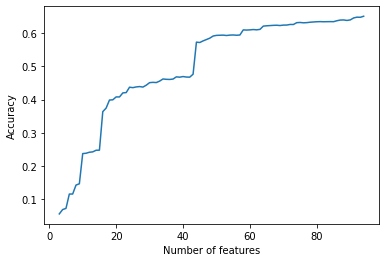

Best score on Train :  0.6514480635288868


In [20]:
#Visualize Train
plt.plot(range(len(count_dict), 2, -1), scores_list)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

print("Best score on Train : ",best_score)


In [21]:
#Accuracy on test
filtered_cols = list(count_dict.keys())[:optimal_feature_number]
X_test_filtered = X_test[filtered_cols]

xgtest = xgb.DMatrix(X_test_filtered, y_test, missing=missing_value_indicator)
test_predictions = best_model.predict(xgtest, ntree_limit=best_model.best_iteration)
current_score = eval_wrapper(test_predictions,y_test)
print("Accuracy on test : ",current_score)



Accuracy on test :  0.5961936712700123


In [22]:

def score_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int) == sv] = data[0, data[0].astype(int) == sv] + bin_offset
    score = scorer(data[1], data[2])
    return score


def apply_offsets(data, offsets):
    for j in range(num_classes):
        data[1, data[0].astype(int) == j] = data[0, data[0].astype(int) == j] + offsets[j]
    return data


# train offsets
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
offset_preds = np.vstack((test_predictions, test_predictions, y_test))
offset_preds = apply_offsets(offset_preds, offsets)
opt_order = [6, 4, 5, 3]
for j in opt_order:
    test_offset = lambda x: -score_offset(offset_preds, x, j) * 100
    offsets[j] = fmin_powell(test_offset, offsets[j], disp=False)

print('Offset Test score is:', eval_wrapper(offset_preds[1], y_test))



Offset Test score is: 0.6454852957307915


In [23]:
# Import key modules/functions for evaluating model performance.
from scikitplot.metrics import plot_roc, plot_confusion_matrix
from sklearn.metrics import classification_report, balanced_accuracy_score

              precision    recall  f1-score   support

           1       0.28      0.38      0.33       922
           2       0.11      0.28      0.16       534
           3       0.15      0.03      0.05      1097
           4       0.08      0.02      0.03      1253
           5       0.14      0.13      0.13      1189
           6       0.18      0.36      0.24      1138
           7       0.27      0.23      0.25      1925
           8       0.72      0.74      0.73      3819

    accuracy                           0.37     11877
   macro avg       0.24      0.27      0.24     11877
weighted avg       0.36      0.37      0.35     11877

AxesSubplot(0.125,0.125;0.62x0.755)


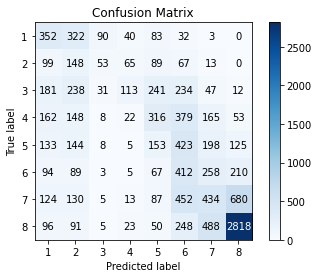

In [24]:
def report(yhat, y):
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)
    print(classification_report(yhat,y))
    print(plot_confusion_matrix(yhat, y))
    
report(offset_preds[1],y_test)

c:\users\91808\appdata\local\programs\python\python36\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


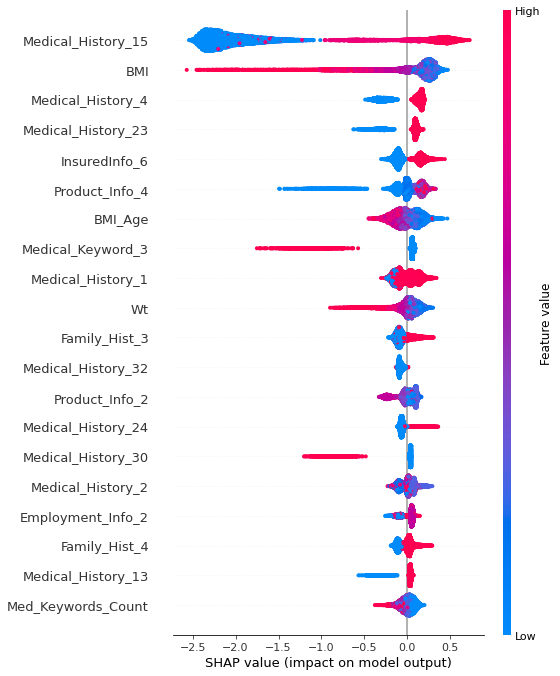

In [25]:
import shap

# Initialise the explainer object in order to calculate SHAP values.
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for the whole test dataset.
shap_values = explainer.shap_values(X_test_filtered)

# Create a summary plot of the SHAP values.
shap.summary_plot(shap_values, X_test_filtered)